In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


####################################################################################################
# # Extract X_train, y_train, X_test, y_test
# X_train = []
# y_train = []
# for images, labels in trainloader:
#     X_train.append(images)
#     y_train.append(labels)

# X_test = []
# y_test = []
# for images, labels in testloader:
#     X_test.append(images)
#     y_test.append(labels)

# # Convert to tensors
# X_train = torch.cat(X_train, dim=0)
# y_train = torch.cat(y_train, dim=0)
# X_test = torch.cat(X_test, dim=0)
# y_test = torch.cat(y_test, dim=0)

# # Print shapes
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

Files already downloaded and verified
Files already downloaded and verified
X_train shape: torch.Size([50000, 3, 32, 32])
y_train shape: torch.Size([50000])
X_test shape: torch.Size([10000, 3, 32, 32])
y_test shape: torch.Size([10000])


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt

class HyperparameterSearch:
    def __init__(self):
        self.hyperparams = {
            'conv_layers': [2, 3],
            'conv_channels': {
                2: [[32, 64], [64, 128]],
                3: [[32, 64, 128], [64, 128, 256]]
            },
            'dense_units': [[128], [128, 64]],
            'learning_rate': [0.001, 0.0001],
            'batch_size': [64]
        }
        self.results = []
        self.total_trials = self._calculate_total_trials()
        self.current_trial = 0

    def _calculate_total_trials(self):
        total = 0
        for conv_layers in self.hyperparams['conv_layers']:
            total += (len(self.hyperparams['conv_channels'][conv_layers]) * 
                     len(self.hyperparams['dense_units']) * 
                     len(self.hyperparams['learning_rate']) * 
                     len(self.hyperparams['batch_size']))
        return total

    def train_and_evaluate(self, model, train_loader, val_loader, hyperparams, epochs=5):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        
        best_val_acc = 0
        
        for epoch in range(epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            
            val_acc = 100.0 * correct / total
            best_val_acc = max(best_val_acc, val_acc)
            
        return best_val_acc

    def search(self, trainset, epochs=5):
        for conv_layers in self.hyperparams['conv_layers']:
            for conv_channels in self.hyperparams['conv_channels'][conv_layers]:
                for dense_units in self.hyperparams['dense_units']:
                    for lr in self.hyperparams['learning_rate']:
                        for batch_size in self.hyperparams['batch_size']:
                            self.current_trial += 1
                            print(f"\nTrial {self.current_trial}/{self.total_trials}")
                            print(f"Remaining trials: {self.total_trials - self.current_trial}")
                            
                            current_params = {
                                'conv_layers': conv_layers,
                                'conv_channels': conv_channels,
                                'dense_units': dense_units,
                                'learning_rate': lr,
                                'batch_size': batch_size
                            }
                            
                            train_size = int(0.8 * len(trainset))
                            val_size = len(trainset) - train_size
                            train_dataset, val_dataset = random_split(trainset, [train_size, val_size])
                            
                            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                            
                            model = CIFAR10Net(
                                conv_layers=conv_layers,
                                conv_channels=conv_channels,
                                dense_units=dense_units
                            )
                            
                            val_acc = self.train_and_evaluate(
                                model, train_loader, val_loader, current_params, epochs
                            )
                            
                            self.results.append({
                                'params': current_params,
                                'val_acc': val_acc
                            })
                            
                            print(f"Configuration: {current_params}")
                            print(f"Validation Accuracy: {val_acc:.2f}%")
        
        best_result = max(self.results, key=lambda x: x['val_acc'])
        print("\nBest configuration:")
        print(f"Parameters: {best_result['params']}")
        print(f"Validation Accuracy: {best_result['val_acc']:.2f}%")
        
        return best_result

# Usage
searcher = HyperparameterSearch()
best_config = searcher.search(trainset, epochs=5)


Trial 1/16
Remaining trials: 15
Configuration: {'conv_layers': 2, 'conv_channels': [32, 64], 'dense_units': [128], 'learning_rate': 0.001, 'batch_size': 64}
Validation Accuracy: 70.59%

Trial 2/16
Remaining trials: 14
Configuration: {'conv_layers': 2, 'conv_channels': [32, 64], 'dense_units': [128], 'learning_rate': 0.0001, 'batch_size': 64}
Validation Accuracy: 56.20%

Trial 3/16
Remaining trials: 13
Configuration: {'conv_layers': 2, 'conv_channels': [32, 64], 'dense_units': [128, 64], 'learning_rate': 0.001, 'batch_size': 64}
Validation Accuracy: 69.39%

Trial 4/16
Remaining trials: 12
Configuration: {'conv_layers': 2, 'conv_channels': [32, 64], 'dense_units': [128, 64], 'learning_rate': 0.0001, 'batch_size': 64}
Validation Accuracy: 53.81%

Trial 5/16
Remaining trials: 11
Configuration: {'conv_layers': 2, 'conv_channels': [64, 128], 'dense_units': [128], 'learning_rate': 0.001, 'batch_size': 64}
Validation Accuracy: 72.94%

Trial 6/16
Remaining trials: 10
Configuration: {'conv_laye

# Use L12c Method

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Define test size
test_size = 0.3  # 30% for testing

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)

# Calculate lengths for train and test
total_size = len(full_dataset)
test_length = int(total_size * test_size)
train_length = total_size - test_length

# Split the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_length, test_length])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                       shuffle=False, num_workers=2)

# Extract X_train, y_train, X_test, y_test
X_train = []
y_train = []
for images, labels in trainloader:
    X_train.append(images)
    y_train.append(labels)

X_test = []
y_test = []
for images, labels in testloader:
    X_test.append(images)
    y_test.append(labels)

# Convert to tensors
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_test = torch.cat(X_test, dim=0)
y_test = torch.cat(y_test, dim=0)

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Files already downloaded and verified
X_train shape: torch.Size([35000, 3, 32, 32])
y_train shape: torch.Size([35000])
X_test shape: torch.Size([15000, 3, 32, 32])
y_test shape: torch.Size([15000])


# VGG16 but i modifies it from the L12c method


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Starting training...
Epoch 1/20:
Train Loss: 1.5580, Train Acc: 42.86%
Test Loss: 1.4577, Test Acc: 49.70%

Epoch 2/20:
Train Loss: 1.1182, Train Acc: 60.50%
Test Loss: 1.0555, Test Acc: 63.71%

Epoch 3/20:
Train Loss: 0.9518, Train Acc: 66.96%
Test Loss: 0.8536, Test Acc: 70.12%

Epoch 4/20:
Train Loss: 0.8464, Train Acc: 70.77%
Test Loss: 0.6917, Test Acc: 75.28%

Epoch 5/20:
Train Loss: 0.7836, Train Acc: 73.18%
Test Loss: 0.6663, Test Acc: 77.10%

Epoch 6/20:
Train Loss: 0.7292, Train Acc: 75.29%
Test Loss: 0.6273, Test Acc: 78.35%

Epoch 7/20:
Train Loss: 0.6793, Train Acc: 77.09%
Test Loss: 0.6350, Test Acc: 78.41%

Epoch 8/20:
Train Loss: 0.6437, Train Acc: 78.48%
Test Loss: 0.5555, Test Acc: 80.90%

Epoch 9/20:
Train Loss: 0.6136, Train Acc: 79.23%
Test Loss: 0.5312, Test Acc: 81.71%

Epoch 10/20:
Train Loss: 0.5887, Train Acc: 80.24%
Test Loss: 0.4832, Test Acc: 83.31%

Epoch 11/20:


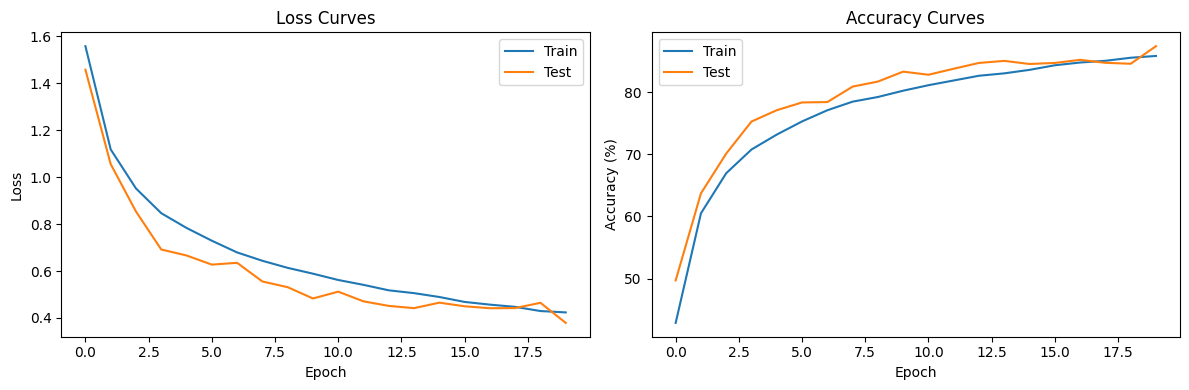


Per-class accuracy:
Accuracy of plane: 86.90%
Accuracy of car: 94.80%
Accuracy of bird: 80.40%
Accuracy of cat: 73.30%
Accuracy of deer: 89.70%
Accuracy of dog: 79.10%
Accuracy of frog: 92.10%
Accuracy of horse: 90.80%
Accuracy of ship: 93.80%
Accuracy of truck: 93.20%


In [2]:
# Basic Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import random

# Data Preprocessing
from sklearn.pipeline import Pipeline

# Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Model Building
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import tensorflow as tf

# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

####################################################################################################

# Load the train dataset
train_url = "https://www.dropbox.com/scl/fi/6tgxge3y0jot8075d5lng/train_imageclass.csv?rlkey=b4cj2ifgbzjlrcmals3t98eu2&st=zmwpkgke&dl=0&raw=1"
# Load local dataset L12c_train.csv
train_url = "L12c_train.csv"
df_train = pd.read_csv(train_url, index_col='ID')

target_col = 'label'
df_train

####################################################################################################

# Set training set and label
X_train = df_train.drop(columns='label')
y_train = df_train['label']

####################################################################################################
df_train['label'].value_counts()

####################################################################################################
# Set training set and label
X_train = df_train.drop(columns='label')
y_train = df_train['label']

# Reshaping x_train into 2D and normalize
X_train = X_train.values.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
y_train = y_train.values

# One-hot encoding of labels
num_classes = 10
y_train = np.eye(num_classes)[y_train.reshape(-1)]
####################################################################################################
classes = np.array(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
                    'sneaker', 'bag', 'boot'])

n_to_show = 8
indices = np.random.choice(range(len(X_train)), n_to_show)
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = X_train[idx].reshape(28, 28)
    label_index = np.argmax(y_train[idx])  # Get the index of the highest probability
    label = classes[label_index]  # Map the index to the corresponding class name
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.5, f'( {label_index} )\n{label}', ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray')  # Display in grayscale

plt.show()


def create_model(hp=None):
    model = Sequential()

    # Convolutional layers with hyperparameter tuning
    for i in range(hp.Int('conv_layers', 2, 4)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same',
            input_shape=(28, 28, 1) if i == 0 else None))
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}_2', values=[3, 5]),
            activation='relu',
            padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense layers with hyperparameter tuning
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=128),
            activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # Optimizer hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
####################################################################################################
# Hyperparameter tuning
import keras_tuner as kt

# Perform the search
tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt',
    overwrite=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Get the best model and hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hyperparameters.values}")

# Build the model using the best hyperparameters
model = tuner.hypermodel.build(best_hyperparameters)

####################################################################################################
history = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_split=0.2, callbacks=[early_stopping])

####################################################################################################
# Plotting accuracy and loss
plt.figure(figsize=(8, 3))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#  Test Accuracy is 90%

Files already downloaded and verified
Files already downloaded and verified
Starting architecture exploration...

Testing architecture with 1 conv layers and 1 dense layers
Progress: Task 1/6
Epoch [1/5]
Test Acc: 49.43%
Epoch [2/5]
Test Acc: 55.25%
Epoch [3/5]
Test Acc: 60.98%
Epoch [4/5]
Test Acc: 60.65%
Epoch [5/5]
Test Acc: 63.50%
Task completed in 1.1 minutes

Testing architecture with 1 conv layers and 2 dense layers
Progress: Task 2/6
Estimated total time remaining: 53.3 minutes
Estimated completion time: 12:44:27
Epoch [1/5]
Test Acc: 47.78%
Epoch [2/5]
Test Acc: 55.24%
Epoch [3/5]
Test Acc: 58.61%
Epoch [4/5]
Test Acc: 61.04%
Epoch [5/5]
Test Acc: 64.44%
Task completed in 1.1 minutes

Testing architecture with 2 conv layers and 1 dense layers
Progress: Task 3/6
Estimated total time remaining: 48.3 minutes
Estimated completion time: 12:40:31
Epoch [1/5]
Test Acc: 53.88%
Epoch [2/5]
Test Acc: 62.62%
Epoch [3/5]
Test Acc: 67.19%
Epoch [4/5]
Test Acc: 68.79%
Epoch [5/5]
Test Acc: 

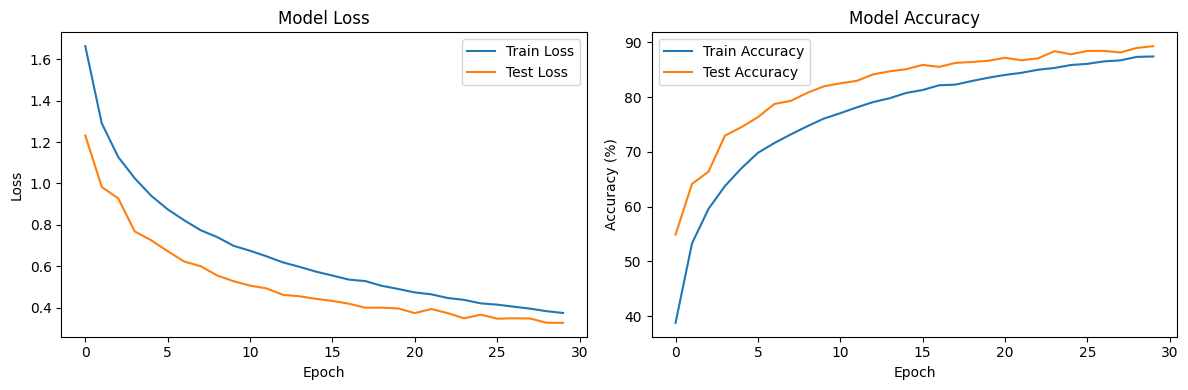

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rates = [0.0001, 0.00037, 0.001]  # Adding learning rate search

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

class CIFAR10CNN(nn.Module):
    def __init__(self, num_conv_layers=3, num_dense_layers=2):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        
        # Define convolutional layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        conv_channels = [64, 128, 256]  # Channels for each conv layer
        
        for i in range(num_conv_layers):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, conv_channels[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]),
                nn.ReLU(),
                nn.Conv2d(conv_channels[i], conv_channels[i]*2, kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]*2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2 + 0.1*i)  # Progressive dropout
            )
            self.conv_layers.append(conv_block)
            in_channels = conv_channels[i]*2
        
        # Calculate input size for dense layers
        self.flatten_size = conv_channels[num_conv_layers-1]*2 * (32 // (2**num_conv_layers))**2
        
        # Define dense layers dynamically
        self.dense_layers = nn.ModuleList()
        dense_sizes = [512, 256]  # Sizes for dense layers
        
        in_features = self.flatten_size
        for i in range(num_dense_layers):
            self.dense_layers.append(nn.Linear(in_features, dense_sizes[i]))
            self.dense_layers.append(nn.ReLU())
            self.dense_layers.append(nn.Dropout(0.4 + 0.1*i))
            in_features = dense_sizes[i]
        
        # Final classification layer
        self.classifier = nn.Linear(in_features, 10)

    def forward(self, x):
        # Pass through conv layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        
        # Final classification
        x = self.classifier(x)
        return x

def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def estimate_total_time(total_tasks, avg_time_per_task, num_epochs):
    # Estimate architecture exploration time
    exploration_time = total_tasks * avg_time_per_task * 5  # 5 epochs per architecture
    
    # Estimate final training time
    final_training_time = avg_time_per_task * num_epochs  # Full training epochs
    
    total_remaining = exploration_time + final_training_time
    return total_remaining

def explore_architectures():
    results = []
    
    total_tasks = len(range(1, 4)) * len(range(1, 3)) * len(learning_rates)  # Including learning rate search
    current_task = 0
    total_time = 0
    
    for conv_layers in range(1, 4):
        for dense_layers in range(1, 3):
            for lr in learning_rates:  # Adding learning rate search
                current_task += 1
                task_start_time = time.time()
                
                print(f"\nTesting architecture with {conv_layers} conv layers, {dense_layers} dense layers, and learning rate {lr}")
                print(f"Progress: Task {current_task}/{total_tasks}")
                
                if current_task > 1:
                    avg_time_per_task = total_time / (current_task - 1)
                    remaining_tasks = total_tasks - current_task
                    
                    # Estimate total remaining time including final training
                    total_remaining = estimate_total_time(remaining_tasks, avg_time_per_task, num_epochs)
                    print(f"Estimated total time remaining: {total_remaining/60:.1f} minutes")
                    print(f"Estimated completion time: {time.strftime('%H:%M:%S', time.localtime(time.time() + total_remaining))}")
                
                # Initialize model with current architecture
                model = CIFAR10CNN(
                    num_conv_layers=conv_layers,
                    num_dense_layers=dense_layers
                ).to(device)
                
                # Initialize optimizer and criterion
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
                criterion = nn.CrossEntropyLoss()
                
                # Train for a few epochs to evaluate architecture
                best_acc = 0
                for epoch in range(5):  # Quick evaluation with 5 epochs
                    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
                    test_loss, test_acc = test(model, testloader, criterion, device)
                    scheduler.step()
                    
                    best_acc = max(best_acc, test_acc)
                    
                    print(f'Epoch [{epoch+1}/5]')
                    print(f'Test Acc: {test_acc:.2f}%')
                
                task_time = time.time() - task_start_time
                total_time += task_time
                print(f"Task completed in {task_time/60:.1f} minutes")
                
                results.append({
                    'conv_layers': conv_layers,
                    'dense_layers': dense_layers,
                    'learning_rate': lr,  # Adding learning rate to results
                    'best_acc': best_acc
                })
    
    # Find best architecture
    best_result = max(results, key=lambda x: x['best_acc'])
    print("\nBest architecture found:")
    print(f"Conv layers: {best_result['conv_layers']}")
    print(f"Dense layers: {best_result['dense_layers']}")
    print(f"Learning rate: {best_result['learning_rate']}")  # Printing best learning rate
    print(f"Accuracy: {best_result['best_acc']:.2f}%")
    
    return best_result

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Run architecture exploration
print("Starting architecture exploration...")
best_architecture = explore_architectures()

# Train final model with best architecture
print("\nTraining final model with best architecture...")
final_model = CIFAR10CNN(
    num_conv_layers=best_architecture['conv_layers'],
    num_dense_layers=best_architecture['dense_layers']
).to(device)

# Initialize for final training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_architecture['learning_rate'])  # Using best learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
print(f"Training on {device}")
best_acc = 0.0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train(final_model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = test(final_model, testloader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    scheduler.step(test_acc)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(final_model.state_dict(), 'best_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Time: {time.time() - start_time:.2f}s\n')
    
    # Early stopping
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()